In [1]:
import os
from tqdm.notebook import tqdm

import math
import threading

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import numpy as np

from py_files.extract import extract_data, extract_metadata
from bycycle import features, cyclepoints, plts
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
from neurodsp.filt import filter_signal

import statsmodels.api as sm

# Import filter function
from neurodsp.filt import filter_signal

import bycycle

from matplotlib.pyplot import cm

from IPython.display import display

%matplotlib inline

In [2]:
# 25, 5, 10, 15
# 10 currently works best, sample size: 1
H_VAL = 10


def find_max(time_series=None, left=np.inf, right=-np.inf):
    errouneous_output = (-1, -np.inf)
    # bound checking
    if len(time_series) == 0:
        return errouneous_output
    if left < 0 or left > len(time_series):
        return errouneous_output
    if left > right:
        return errouneous_output
    if right > len(time_series):
        return errouneous_output
    # corner case
    if left == right:
        # super trivial result but what else?
        return (left, time_series[left])

    idx = -1
    max_val = time_series[0]
    for i in range(left, right):
        if time_series[i] > max_val:
            idx = i
            max_val = time_series[i]
        # else:
        #     outstring = "time_series[i]=" + str(time_series[i])+", max_val="+str(max_val)+". We claim that " + str(
        #         max_val) + " >= " + str(time_series[i])+". i.e. max_val >= time_series[i]"

    return(idx, max_val)


def find_min(time_series=None, left=np.inf, right=-np.inf):
    errouneous_output = (-1, -np.inf)
    # bound checking
    if len(time_series) == 0:
        return errouneous_output
    if left < 0 or left > len(time_series):
        return errouneous_output
    if left > right:
        return errouneous_output
    if right > len(time_series):
        return errouneous_output
    # corner case
    if left == right:
        # super trivial result but what else?
        return (left, time_series[left])

    idx = -1
    max_val = time_series[0]
    for i in range(left, right):
        if time_series[i] < max_val:
            idx = i
            max_val = time_series[i]
        # else:
        #     outstring = "time_series[i]=" + str(time_series[i])+", max_val="+str(max_val)+". We claim that " + str(
        #         max_val) + " <= " + str(time_series[i])+". i.e. max_val >= time_series[i]"

    return(idx, max_val)


def disc_derivative(time_series, x_val, h_val):
    # sign(f'(x)) = sign(f(x+h) - f(x))
    if x_val+h_val in range(0, len(time_series)):
        deriv = (time_series[x_val+h_val]-time_series[x_val])
        if deriv == 0:
            return 0
        if deriv > 0:
            return 1
        else:
            return -1
    return int(0)


def time_series_polarity_change(time_series, idx, offset, direction):
    if direction < 0:
        offset = -offset

    extreme_bound = None
    if direction > 0:
        extreme_bound = len(time_series)
    else:
        extreme_bound = 0
    initial_derivative = disc_derivative(
        time_series=time_series, x_val=idx, h_val=offset)
    while initial_derivative == 0:
        idx += offset
        initial_derivative = disc_derivative(
            time_series=time_series, x_val=idx, h_val=offset)
    for i in range(idx, extreme_bound, offset):
        new_derivative = disc_derivative(
            time_series=time_series, x_val=i, h_val=offset)
        if new_derivative != initial_derivative:
            return i

    return -1

# 'linearization_function' takes and returns the following parameters:
#     time_series: 1d np array
#     interval: int
#
# under the assumption that time_series resembles a countinuous function
# interval must be an interger


def linear_smoothing(time_series, interval):
    if type(interval) != int or len(time_series) == 0 or interval <= 0:
        return None
    retArray = np.zeros(len(time_series))

    iterations = math.floor(float(len(time_series))/float(interval))
    remainder = len(time_series) % interval
    for i in range(iterations):
        y2 = time_series[((i+1)*interval)-1]
        y1 = time_series[i*interval]
        # print(interval)
        slope = float(y2 - y1)/float(interval)
        for j in range(interval):
            retArray[i*interval + j] = time_series[i*interval] + j*slope

    if remainder > 0:
        y2 = time_series[i+remainder]
        y1 = time_series[i]
        slope = float(y2 - y1)/float(interval)
        for i in range(remainder):
            retArray[iterations*interval +
                     i] = time_series[iterations*interval] + i*slope
    return retArray


def gaussian(x, a, b, c):
    return a*np.exp(c*((x-b)**2))

def plot_gaussian(x, a, b, c):
    func = a*np.exp(c*((x-b)**2))
    x=np.linspace(0,len(func),func)
    plt.plot(x, func)


def fit_curve(sig=None, p0=[], bounds=(), x0=1):
    p, _ = curve_fit(f=gaussian, xdata=np.linspace(
        0, len(sig), len(sig)), ydata=sig, p0=p0, bounds=bounds)
    return p


In [3]:
# Data paths
dir_path = '/home/guarian/HOME/coding/python/su22_ecg/ecg_param/data/'
files_dat = [i for i in sorted(os.listdir(dir_path)) if i.endswith('dat')]
files_hea = [i for i in sorted(os.listdir(dir_path)) if i.endswith('hea')]
files_hea = [i for i in files_hea if i != '0400.hea'] # missing one participant's data

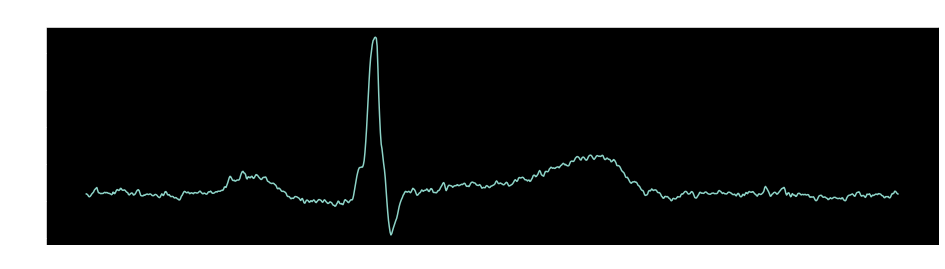

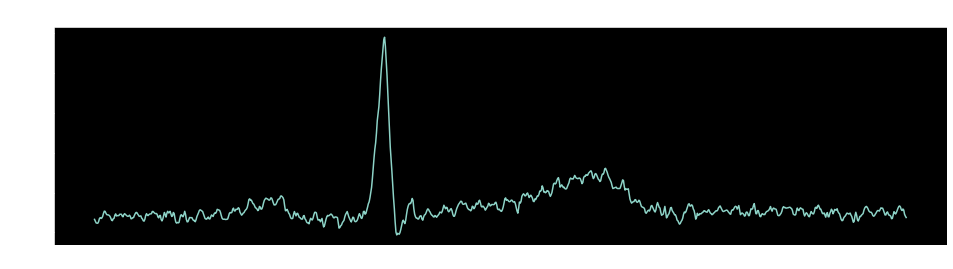

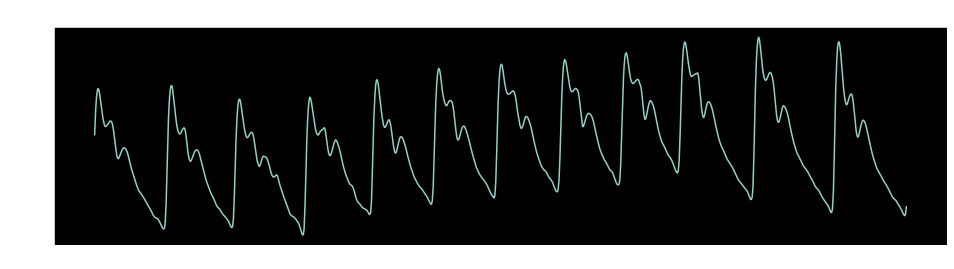

In [4]:
# Extract single subject
sigs, metadata = extract_data(
    os.path.join(dir_path, files_dat[0]),
    os.path.join(dir_path, files_hea[0]),
    raw_dtype='int16'
)

# Each subject has three 'channels': two ecg and one pulse
plt.figure(0, figsize=(16, 4))
plt.plot(sigs[0][500:1500])
plt.title('ECG', size=20)
plt.figure(1, figsize=(16, 4))
plt.title('ECG2', size=20)
plt.plot(sigs[1][500:1500])
plt.figure(2, figsize=(16, 4))
plt.title('BP', size=20)
plt.plot(sigs[2][300000:310000])

## Finding peaks with Scipy

In [5]:
data = sigs[0]
fs = 1000
f_range_hi = (1, None)

[     0      1      2 ... 900398 900399 900400]
[nan nan nan ... nan nan nan]


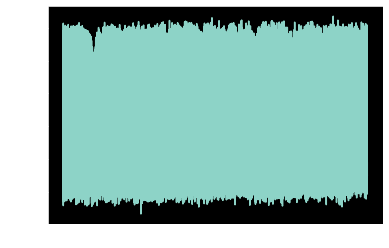

In [6]:
# Highpass filter to remove drift
sig_filt = filter_signal(data, fs, 'highpass', f_range_hi)
times = np.arange(0, sig_filt.shape[0])
print(times)

# smoothing for finding control points
datalen = len(data)
# https://www.statsmodels.org/dev/generated/statsmodels.nonparametric.smoothers_lowess.lowess.html
data_smoothed = linear_smoothing(sig_filt,H_VAL)
print(data_smoothed)
plt.plot(times, data_smoothed)


In [7]:
# First find R peaks
peaks = find_peaks(sig_filt, height=10000, distance=500)
idx_rvals = peaks[0] # spike indices
amp_rvals = peaks[1]['peak_heights'] # spike amplitudes

In [8]:
# Number of R peaks found
idx_rvals.shape

(1058,)

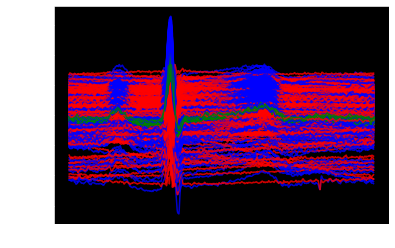

In [9]:
# Plotting all windowed cycles to find generalizable window length
for idx, cycle in enumerate(idx_rvals[1:]):
    #times declaratio nmoved to sig_filt declaration. saves on allocations and increases availability.

    # create window indices
    window_length = (300, 600)  # in ms
    window_pre = int(window_length[0])
    window_post = int(window_length[1])

    # get window
    window_cycle_pre = (cycle-window_pre)
    window_cycle_post = (cycle+window_post)

    # get window for times as well
    windowed_times = times[(cycle-window_pre):
                           (cycle+window_post)]
    windowed_times = np.arange(0, windowed_times.shape[0])

    # get data window
    windowed_data = data[window_cycle_pre:window_cycle_post]
    windowed_smoothed_data = data_smoothed[window_cycle_pre:window_cycle_post]

    plt.plot(windowed_times, windowed_data, 'b', alpha=0.8)
    plt.plot(windowed_times, windowed_data-windowed_smoothed_data, 'r', alpha=0.8)
    plt.plot(windowed_times, windowed_smoothed_data, 'g', alpha=0.8)
    #plt.plot(cycle, amp_rvals[idx], 'o')

plt.show()


In [10]:
idx_rvals.shape

(1058,)

all cycles plotted


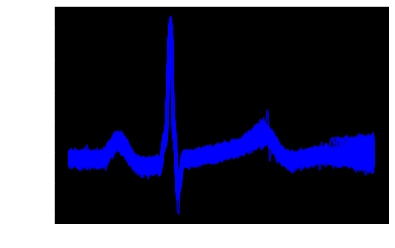

failing_cases: [478, 575, 0, 82, 91, 97, 475, 494, 666]


In [11]:
idx_pvals = np.zeros(idx_rvals.shape)
amp_pvals = np.zeros(idx_rvals.shape)
idx_max = -np.inf
peak_max = -np.inf

p = []
q = []
r = []
s = []
t = []
u = []
qs = []
windowed_data_collection = []
smoothed_windowed_data_collection = []
rolling_index = 0
cycle_starts = []
cycle_lengths = []
failing_cases = [478, 575]
errstring = 'Failing case: '
for idx, cycle in enumerate(idx_rvals[:]):
    if idx in failing_cases:
        continue
    times = np.arange(0, sig_filt.shape[0])
    # create window indices
    window_length = (300, 600)  # in ms
    window_pre = int(window_length[0])
    window_post = int(window_length[1])
    # get window
    window_cycle_pre = (cycle-window_pre)
    window_cycle_post = (cycle+window_post)
    # get window for times as well
    windowed_times = times[(cycle-window_pre):
                           (cycle+window_post)]
    windowed_times = np.arange(0, windowed_times.shape[0])
    # get data window
    windowed_data = sig_filt[window_cycle_pre:window_cycle_post]
    windowed_smoothed_data = data_smoothed[window_cycle_pre:window_cycle_post]
    # P peaks
    r_idx = 299
    r_idx, _ = find_max(windowed_data, r_idx-50, r_idx+50)
    if r_idx == -1 or r_idx == len(windowed_data):
        #print(errstring + str(idx))
        failing_cases.append(idx)
        continue
    q_idx = time_series_polarity_change(
        time_series=windowed_smoothed_data, idx=r_idx, offset=H_VAL, direction=-1)
    if q_idx == -1:
        #print(errstring + str(idx))
        failing_cases.append(idx)
        continue
        
    p_idx = time_series_polarity_change(
        time_series=windowed_smoothed_data, idx=q_idx, offset=H_VAL, direction=-1)
    if p_idx == -1:
        #print(errstring + str(idx))
        failing_cases.append(idx)
        continue
    smooth_r_idx, _ = find_max(
        time_series=windowed_smoothed_data, left=0, right=len(windowed_smoothed_data))
    if smooth_r_idx == -1 or smooth_r_idx == len(windowed_smoothed_data):
        #print(errstring + str(idx))
        failing_cases.append(idx)
        continue
    p_idx, _ = find_max(time_series=windowed_smoothed_data,
                        left=0, right=q_idx)
    if p_idx == -1 or p_idx == len(windowed_smoothed_data):
        #print(errstring + str(idx))
        failing_cases.append(idx)
        continue
    # print(smooth_r_idx)
    r_increase_or_decrease = disc_derivative(
        time_series=windowed_data, x_val=smooth_r_idx, h_val=1)
    if r_increase_or_decrease > 0:
        smooth_r_idx = smooth_r_idx+25
    s_idx = time_series_polarity_change(
        time_series=windowed_smoothed_data, idx=smooth_r_idx, offset=5, direction=1)
    if s_idx == -1:
        #print(errstring + str(idx))
        failing_cases.append(idx)
        continue
    # print(s_idx)
    t_idx, _ = find_max(time_series=windowed_smoothed_data,
                        left=s_idx, right=len(windowed_smoothed_data))
    if t_idx == -1 or t_idx == len(windowed_smoothed_data):
        #print(errstring + str(idx))
        failing_cases.append(idx)
        continue
    # print(t_idx)
    left_u_bound = time_series_polarity_change(
        time_series=windowed_smoothed_data, idx=t_idx, offset=H_VAL, direction=1)
    right_u_bound = time_series_polarity_change(time_series=windowed_smoothed_data, idx=len(
        windowed_smoothed_data)-1, offset=H_VAL, direction=-1)
    u_idx, _ = find_max(time_series=windowed_smoothed_data,
                        left=left_u_bound, right=right_u_bound)
    
    if left_u_bound == -1 or right_u_bound == -1 or u_idx == -1 or u_idx == len(windowed_smoothed_data):
        #print(errstring + str(idx))
        failing_cases.append(idx)
        continue

    # Now we use the real (adjusted) R value.
    r_idx = 299

    # adding these to an array to make the matplotlib stuff faster.
    # I think it replots the whole graph each time plot is called,
    # so I'll call it once. Can't hurt
    # It Worked!!!!!
    p.append(p_idx)
    q.append(q_idx)
    r.append(r_idx)
    s.append(s_idx)
    t.append(t_idx)
    u.append(u_idx)
    qs.append(s_idx-q_idx)
    windowed_data_collection.append(windowed_data)
    smoothed_windowed_data_collection.append(windowed_smoothed_data)
    cycle_starts.append(window_cycle_pre)
    cycle_lengths.append(len(windowed_data))

    plt.plot(windowed_times, sig_filt[window_cycle_pre:window_cycle_post], 'b', alpha=0.8)
    # plt.plot(windowed_times, windowed_data-windowed_smoothed_data, 'r', alpha=0.8)
    # plt.plot(windowed_times, windowed_smoothed_data, 'r', alpha=0.8)
    plt.plot(windowed_times[p_idx], sig_filt[p_idx], 'o')
    plt.plot(windowed_times[q_idx], sig_filt[q_idx], 'o')
    plt.plot(windowed_times[r_idx], sig_filt[r_idx], 'o')
    plt.plot(windowed_times[s_idx], sig_filt[s_idx], 'o')
    plt.plot(windowed_times[t_idx], sig_filt[t_idx], 'o')
    plt.plot(windowed_times[u_idx], sig_filt[u_idx], 'o')
print("all cycles plotted")
plt.show()

print("failing_cases: " + str(failing_cases))

p_co = []
q_co = []
r_co = []
s_co = []
t_co = []
u_co = []

# asserting here that all the arrays are the same length
for i in range(len(p)):
    p_co.append(windowed_data[p[i]])
    q_co.append(windowed_data[q[i]])
    r_co.append(windowed_data[r[i]])
    s_co.append(windowed_data[s[i]])
    t_co.append(windowed_data[t[i]])
    u_co.append(windowed_data[u[i]])



Gradient Descent Gaussian Stuff

In [23]:
data_for_df = []
divisors = np.linspace(1, 70, 70)
smoothing_interval=H_VAL

for k in range(len(windowed_data_collection)):
    # changed or added everything above here
    # print("one cycle plotted alone")
    # plt.plot(np.linspace(0,cycle_lengths[0],cycle_lengths[0]), windowed_data_collection[0], 'r')
    plt.show()

    highests = []
    highest_idx = - 1
    smoothing_interval=0

    # https://stackoverflow.com/questions/4971269/how-to-pick-a-new-color-for-each-plotted-line-within-a-figure-in-matplotlib
    color = iter(cm.rainbow(np.linspace(0, 1, len(divisors))))
    shouldibreak = False
    for i in range(len(divisors)):
        # if i==0:
        #     plt.plot(np.linspace(0,cycle_lengths[0],cycle_lengths[0]), smoothed_data, 'g', alpha=0.8)
        #     continue
        smoothing_interval = math.floor(qs[k]/divisors[i])
        if smoothing_interval == 0:
            smoothing_interval = 1
        # print(qs[i], divisors[i], smoothing_interval)
        smoothed_data = linear_smoothing(
            sig_filt[cycle_starts[k]:cycle_starts[k]+cycle_lengths[k]], smoothing_interval)
        if smoothed_data is None:
            # print("smoothing failed")
            shouldibreak = True
            break
        highests.append(smoothed_data[650])
        # plt.plot(np.linspace(0,cycle_lengths[0],cycle_lengths[0]), smoothed_data, next(color), linewidth=1)

    if shouldibreak:
        continue
    # print("highests: " + str(highests))
    plt.show()

    ctrl_pt_bounds = []
    sm_data = None

    # print(str(len(divisors)))
    # print("smoothing_interval: " + str(smoothing_interval))
    smoothed_data = linear_smoothing(
        sig_filt[cycle_starts[k]:cycle_starts[k]+cycle_lengths[k]], smoothing_interval)
    # plt.plot(np.linspace(0,cycle_lengths[0],cycle_lengths[0]), smoothed_data, 'b', linewidth=3)
    for j in range(len(smoothed_data)-1):
        if (smoothed_data[j] >= 0 and smoothed_data[j+1] <= 0) or (smoothed_data[j] <= 0 and smoothed_data[j+1] >= 0):
            # plt.plot(i,0,color='r',marker='o', markersize=10)
            ctrl_pt_bounds.append(j)
    sm_data = smoothed_data

    # plt.show()

    p_series = sm_data[ctrl_pt_bounds[0]:ctrl_pt_bounds[1]]
    # plt.plot(np.linspace(0,len(p_series),len(p_series)), p_series, 'r', linewidth=3)
    p_gaussian = fit_curve(
        sig=p_series, p0=[2000, 35, -1], bounds=([0, 0, -1e9], [1e9, 55, 0]), x0=1)
    # plt.plot(np.linspace(0,len(p_series),len(p_series)), gaussian(np.linspace(0,len(p_series),len(p_series)), *p_gaussian), 'g', linewidth=3)
    # plt.show()

    q_series = sm_data[ctrl_pt_bounds[1]:ctrl_pt_bounds[2]]
    q_gaussian = fit_curve(
        sig=q_series, p0=[-2000, 35, -1], bounds=([-1e9, 0, -1e9], [0, 55, 0]), x0=1)

    r_series = sm_data[ctrl_pt_bounds[2]:ctrl_pt_bounds[3]]
    r_gaussian = fit_curve(
        sig=r_series, p0=[2000, 35, -1], bounds=([0, 0, -1e9], [1e9, 55, 0]), x0=1)

    s_series = sm_data[ctrl_pt_bounds[3]:ctrl_pt_bounds[4]]
    s_gaussian = fit_curve(
        sig=s_series, p0=[-2000, 35, -1], bounds=([-1e9, 0, -1e9], [0, 55, 0]), x0=1)

    t_series = sm_data[ctrl_pt_bounds[4]:ctrl_pt_bounds[5]]
    t_gaussian = fit_curve(
        sig=t_series, p0=[2000, 35, -1], bounds=([0, 0, -1e9], [1e9, 140, 0]), x0=1)
    # plt.plot(np.linspace(0, len(t_series), len(t_series)),
    #         t_series, 'r', linewidth=3)
    # plt.show()

    p_gaussian[1] += ctrl_pt_bounds[0]
    q_gaussian[1] += ctrl_pt_bounds[1]
    r_gaussian[1] += ctrl_pt_bounds[2]
    s_gaussian[1] += ctrl_pt_bounds[3]
    t_gaussian[1] += ctrl_pt_bounds[4]
    # plt.plot(np.linspace(0, cycle_lengths[0], cycle_lengths[0]), gaussian(
    #     np.linspace(0, cycle_lengths[0], cycle_lengths[0]), *p_gaussian), 'g', linewidth=3)
    # plt.plot(np.linspace(0, cycle_lengths[0], cycle_lengths[0]), gaussian(
    #     np.linspace(0, cycle_lengths[0], cycle_lengths[0]), *q_gaussian), 'g', linewidth=3)
    # plt.plot(np.linspace(0, cycle_lengths[0], cycle_lengths[0]), gaussian(
    #     np.linspace(0, cycle_lengths[0], cycle_lengths[0]), *r_gaussian), 'g', linewidth=3)
    # plt.plot(np.linspace(0, cycle_lengths[0], cycle_lengths[0]), gaussian(
    #     np.linspace(0, cycle_lengths[0], cycle_lengths[0]), *s_gaussian), 'g', linewidth=3)
    # plt.plot(np.linspace(0, cycle_lengths[0], cycle_lengths[0]), gaussian(
    #     np.linspace(0, cycle_lengths[0], cycle_lengths[0]), *t_gaussian), 'g', linewidth=3)
    # plt.show()

    a = gaussian(np.linspace(
        0, cycle_lengths[0], cycle_lengths[0]), *p_gaussian)
    b = gaussian(np.linspace(
        0, cycle_lengths[0], cycle_lengths[0]), *q_gaussian)
    c = gaussian(np.linspace(
        0, cycle_lengths[0], cycle_lengths[0]), *r_gaussian)
    d = gaussian(np.linspace(
        0, cycle_lengths[0], cycle_lengths[0]), *s_gaussian)
    e = gaussian(np.linspace(
        0, cycle_lengths[0], cycle_lengths[0]), *t_gaussian)

    # plt.plot(np.linspace(0, cycle_lengths[0], cycle_lengths[0]),
    #         sig_filt[cycle_starts[0]:cycle_starts[0]+cycle_lengths[0]], 'r', linewidth=3)
    # plt.show()
    # plt.plot(np.linspace(
    #     0, cycle_lengths[0], cycle_lengths[0]), a+b+c+d+e, 'r', linewidth=3)
    # plt.show()
    # # the stuff that matters:
    # print(p_gaussian)
    # print(q_gaussian)
    # print(r_gaussian)
    # print(s_gaussian)
    # print(t_gaussian)

    # and below here and in between to match the indices from the top section
    newData = [k, p_gaussian[0], p_gaussian[1], p_gaussian[2], q_gaussian[0], q_gaussian[1], q_gaussian[2], r_gaussian[0], r_gaussian[1], r_gaussian[2], s_gaussian[0], s_gaussian[1], s_gaussian[2], t_gaussian[0], t_gaussian[1],
               t_gaussian[2]]
    data_for_df.append(newData)

# print(data_for_df)
x = pd.DataFrame(data_for_df, columns=['cycle index', 'p_a', 'p_b', 'p_c', 'q_a',
                 'q_b', 'q_c', 'r_a', 'r_b', 'r_c', 's_a', 's_b', 's_c', 't_a', 't_b', 't_c'])
display(x)
# x.to_csv("gaussianTable.csv")

/home/guarian/.local/lib/python3.10/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


,cycle index,p_a,p_b,p_c,q_a,q_b,q_c,r_a,r_b,r_c,s_a,s_b,s_c,t_a,t_b,t_c
0,0,1901.969929,154.857494,-0.001185,-2457.778786,238.000000,-0.000322,21395.535066,299.151773,-0.011197,-6336.032459,323.269355,-0.010497,2000.000000,477.000000,-1.000000
1,1,2338.915565,156.133428,-0.001872,-2541.444836,235.000000,-0.000338,20156.762868,299.149750,-0.012287,-3287.465959,313.000000,-0.000204,4000.191000,561.010759,-0.000479
2,2,2000.000000,39.000000,-1.000000,-1209.541909,61.000000,-0.000058,2000.000000,156.000000,-1.000000,-2000.000000,157.000000,-1.000000,2420.325930,153.523684,-0.002585
3,3,2273.176529,148.645870,-0.001579,-2000.000000,212.000000,-1.000000,2000.000000,216.000000,-1.000000,-2411.474441,235.238521,-0.000423,20126.796388,299.116019,-0.013262
4,4,1760.385299,149.265429,-0.001895,-2609.036608,227.000000,-0.000294,19648.977040,298.303183,-0.012251,-4125.871259,313.000000,-0.000462,2000.000000,487.000000,-1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1044,1044,1862.016776,141.251613,-0.003273,-2000.000000,201.000000,-1.000000,2000.000000,202.000000,-1.000000,-1702.874432,225.000000,-0.000156,21484.110373,297.719910,-0.012693
1045,1045,2000.000000,90.000000,-1.000000,-1080.912618,84.078217,-0.000403,1086.367502,146.689026,-0.001371,-2000.000000,206.000000,-1.000000,2000.000000,207.000000,-1.000000
1046,1046,1891.369584,140.190070,-0.002229,-2000.000000,192.000000,-1.000000,2000.000000,195.000000,-1.000000,-1956.656389,226.000000,-0.000181,20858.281243,297.983697,-0.011151
1047,1047,1945.570274,143.566332,-0.004318,-2000.000000,195.000000,-1.000000,2000.000000,204.000000,-1.000000,-2171.242682,225.000000,-0.000301,21227.570024,298.241566,-0.011394


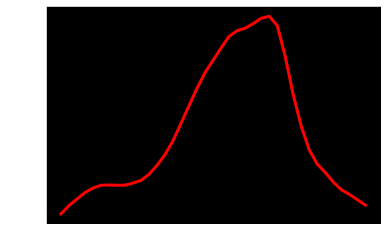

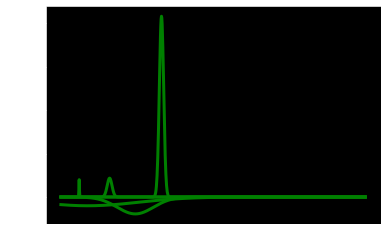

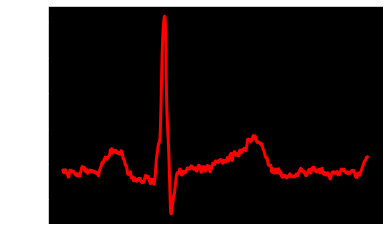

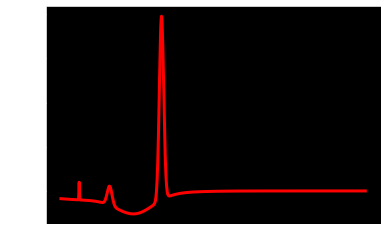

[ 2.0e+03  5.4e+01 -1.0e+00]
[-1.00781345e+03  7.90000000e+01 -2.26834377e-05]
[ 2.16715663e+03  1.43940929e+02 -9.85146770e-03]
[-1.94466520e+03  2.20000000e+02 -1.74724017e-04]
[ 2.07936304e+04  2.97441411e+02 -1.23700280e-02]


In [22]:
p_series = sm_data[ctrl_pt_bounds[0]:ctrl_pt_bounds[1]]
# plt.plot(np.linspace(0,len(p_series),len(p_series)), p_series, 'r', linewidth=3)
p_gaussian = fit_curve(
    sig=p_series, p0=[2000, 35, -1], bounds=([0, 0, -1e9], [1e9, 55, 0]), x0=1)
# plt.plot(np.linspace(0,len(p_series),len(p_series)), gaussian(np.linspace(0,len(p_series),len(p_series)), *p_gaussian), 'g', linewidth=3)
plt.show()

q_series = sm_data[ctrl_pt_bounds[1]:ctrl_pt_bounds[2]]
q_gaussian = fit_curve(
    sig=q_series, p0=[-2000, 35, -1], bounds=([-1e9, 0, -1e9], [0, 55, 0]), x0=1)

r_series = sm_data[ctrl_pt_bounds[2]:ctrl_pt_bounds[3]]
r_gaussian = fit_curve(
    sig=r_series, p0=[2000, 35, -1], bounds=([0, 0, -1e9], [1e9, 55, 0]), x0=1)

s_series = sm_data[ctrl_pt_bounds[3]:ctrl_pt_bounds[4]]
s_gaussian = fit_curve(
    sig=s_series, p0=[-2000, 35, -1], bounds=([-1e9, 0, -1e9], [0, 55, 0]), x0=1)

t_series = sm_data[ctrl_pt_bounds[4]:ctrl_pt_bounds[5]]
t_gaussian = fit_curve(
    sig=t_series, p0=[2000, 35, -1], bounds=([0, 0, -1e9], [1e9, 140, 0]), x0=1)
plt.plot(np.linspace(0, len(t_series), len(t_series)),
         t_series, 'r', linewidth=3)
plt.show()

p_gaussian[1] += ctrl_pt_bounds[0]
q_gaussian[1] += ctrl_pt_bounds[1]
r_gaussian[1] += ctrl_pt_bounds[2]
s_gaussian[1] += ctrl_pt_bounds[3]
t_gaussian[1] += ctrl_pt_bounds[4]
plt.plot(np.linspace(0, cycle_lengths[0], cycle_lengths[0]), gaussian(
    np.linspace(0, cycle_lengths[0], cycle_lengths[0]), *p_gaussian), 'g', linewidth=3)
plt.plot(np.linspace(0, cycle_lengths[0], cycle_lengths[0]), gaussian(
    np.linspace(0, cycle_lengths[0], cycle_lengths[0]), *q_gaussian), 'g', linewidth=3)
plt.plot(np.linspace(0, cycle_lengths[0], cycle_lengths[0]), gaussian(
    np.linspace(0, cycle_lengths[0], cycle_lengths[0]), *r_gaussian), 'g', linewidth=3)
plt.plot(np.linspace(0, cycle_lengths[0], cycle_lengths[0]), gaussian(
    np.linspace(0, cycle_lengths[0], cycle_lengths[0]), *s_gaussian), 'g', linewidth=3)
plt.plot(np.linspace(0, cycle_lengths[0], cycle_lengths[0]), gaussian(
    np.linspace(0, cycle_lengths[0], cycle_lengths[0]), *t_gaussian), 'g', linewidth=3)
plt.show()

a = gaussian(np.linspace(0, cycle_lengths[0], cycle_lengths[0]), *p_gaussian)
b = gaussian(np.linspace(0, cycle_lengths[0], cycle_lengths[0]), *q_gaussian)
c = gaussian(np.linspace(0, cycle_lengths[0], cycle_lengths[0]), *r_gaussian)
d = gaussian(np.linspace(0, cycle_lengths[0], cycle_lengths[0]), *s_gaussian)
e = gaussian(np.linspace(0, cycle_lengths[0], cycle_lengths[0]), *t_gaussian)

plt.plot(np.linspace(0, cycle_lengths[0], cycle_lengths[0]),
         sig_filt[cycle_starts[0]:cycle_starts[0]+cycle_lengths[0]], 'r', linewidth=3)
plt.show()
plt.plot(np.linspace(
    0, cycle_lengths[0], cycle_lengths[0]), a+b+c+d+e, 'r', linewidth=3)
plt.show()
# the stuff that matters:
print(p_gaussian)
print(q_gaussian)
print(r_gaussian)
print(s_gaussian)
print(t_gaussian)

newData = [p_gaussian[0], p_gaussian[1], p_gaussian[2], q_gaussian[0], q_gaussian[1], q_gaussian[2], r_gaussian[0], r_gaussian[1], r_gaussian[2], s_gaussian[0], s_gaussian[1], s_gaussian[2], t_gaussian[0], t_gaussian[1],
             t_gaussian[2]]

In [ ]:
idx_rvals_crop = np.where(np.logical_and(idx_rvals>=500, idx_rvals<=5000))
idx_pvals_crop = np.where(np.logical_and(idx_pvals>=500, idx_pvals<=5000))

plt.plot(times[500:5000], sig_filt[500:5000])
plt.plot(idx_rvals[idx_rvals_crop[0]], amp_rvals[idx_rvals_crop[0]], 'o')
plt.plot(idx_pvals[idx_pvals_crop[0]], amp_rvals[idx_pvals_crop[0]], 'o')
plt.show()


In [ ]:
idx_pvals_crop

In [ ]:
idx_rvals_crop

In [ ]:
idx_pvals[50:55]

## Finding peaks with Bycycle

In [ ]:
fs = 1000
f_range_hi = (1, None)
f_range_band = (4, 10)

In [ ]:
# Highpass filter to remove drift
sig_filt = filter_signal(sigs[0], fs, 'highpass', f_range_hi)

In [ ]:
peaks, troughs = bycycle.cyclepoints.find_extrema(sig_filt, fs, f_range_band)

In [ ]:
bycycle.plts.plot_cyclepoints_array(sig_filt, fs, peaks=peaks, troughs=troughs, xlim=(25, 60))

In [ ]:
peaks.shape

In [ ]:
sig_peaks = sig_filt[peaks]

In [ ]:
# Filter the peaks to only find the ones that are above 1 standard deviation of the mean voltage
mean = np.mean(sig_peaks)
std = np.std(sig_peaks)
mask = sig_peaks > (mean+std)

In [ ]:
r_vals = sig_peaks[mask]

In [ ]:
r_vals_times = peaks[mask]

In [ ]:
r_vals

In [ ]:
plt.plot(sig_filt)
plt.plot(r_vals_times, r_vals)